In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [167]:
from utils.load_mnist_1 import *

import numpy as np


In [168]:
# import ResNet and configure it 
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Activation, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam, Adadelta
from keras.applications import ResNet50
from keras.applications import resnet50 as resnet50
from keras.preprocessing import image
from keras.models import Model 
from keras.utils import to_categorical
from keras.regularizers import l2


In [169]:
print("loaded data set from mnist_1 method")


loaded data set from mnist_1 method


In [170]:
def resnet_transfer_preparedata(kind='train', no=0): 
    import skimage.transform

    imgs, lbls = [], []

    if kind == 'train': 
        imgs, lbls = load_images_train_32_32_rgb()
    elif kind == "test": 
        imgs, lbls = load_images_test_32_32_rgb()


    if no != 0: 
        imgs = imgs[:no]
        lbls = lbls[:no]

    imgs_resize = []
    no_images = len(imgs)
    status_print = "resizing {} / " +  str(no_images)
    print(status_print.format(0), end="\r")

    for i in range(len(imgs)): 
        img = skimage.transform.resize(
            imgs[i], 
            (38,38),
            mode ='constant')
        imgs_resize.append(img)
        if i % 500 == 0: 
            print(status_print.format(i), end="\r")

    imgs_resize = np.array(imgs_resize)
    print("resizing complete: " + str(imgs_resize.shape))

    lbls_str = image_class_to_str(lbls)
    return imgs_resize, lbls, lbls_str


In [171]:
train_images, train_labels, train_labels_str = resnet_transfer_preparedata(no=0)
test_images, test_labels, test_labels_str = resnet_transfer_preparedata('test', no=0)

train_labels_cat = to_categorical(train_labels, num_classes=10)
test_labels_cat = to_categorical(test_labels, num_classes=10)


resizing complete: (60000, 38, 38, 3)
resizing complete: (10000, 38, 38, 3)


In [172]:


base_model = ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = [38,38,3]
)


/data/anaconda/envs/py35/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [173]:
# assuming that these will do extraction of basic features, and retrain later ones
# going with the assumption that this set is very differnt from the orignal set


for l in base_model.layers[:10]: 
    l.trainable = False


In [174]:
base_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 38, 38, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 44, 44, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 19, 19, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 19, 19, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [175]:

added_layers = base_model.output 

# Prior to GAP, one would flatten your tensor and then add a few fully connected layers in your model. 
# The problem is that a bunch of parameters in your model end up being attributed to the dense layers and 
# could potentially lead to overfitting. A natural solution was to add dropout to help regulate that.

# However a few years ago, the idea of having a Global Average Pooling came into play. 
# GAP can be viewed as alternative to the whole flatten FC Dropout paradigm. GAP helps prevent overfitting 
# by doing an extreme form of reduction. Given a H X W X D tensor, GAP will average the H X W features 
# into a single number and reduce the tensor into a 1 X 1 X D tensor.

# The original paper simply applied GAP and then a softmax. However, it's now common to have GAP followed by a FC layer.


added_layers = GlobalAveragePooling2D()(added_layers)#  Flatten()(added_layers)
# added_layers = Dropout(0.7)(added_layers)

# initial run was showing very high variance (acc on trainng is good, but acc on val is very poor)
# so i added regulisation 
added_layers = Dense(128, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(added_layers)
added_layers = Activation('relu')(added_layers)
# added_layers = BatchNormalization()(added_layers)
added_layers = Dense(128, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(added_layers)
added_layers = Activation('relu')(added_layers)

preds = Dense(10, activation ='softmax')(added_layers)

final_model = Model(input = base_model.input, outputs=preds)

final_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 38, 38, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 44, 44, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 19, 19, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 19, 19, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [176]:
adam = Adam(lr=0.0001)
final_model.compile(optimizer= Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])


In [177]:
train_images = train_images[:1000]
train_labels_cat = train_labels_cat[:1000]

test_images = test_images[:250]
test_labels_cat = test_labels_cat[:250]

print(train_images.shape)
print(test_images.shape)
print(train_labels_cat.shape)
print(test_labels_cat.shape)

print(np.max(train_images), np.min(train_images))
print(np.max(test_images), np.min(test_images))

(1000, 38, 38, 3)
(250, 38, 38, 3)
(1000, 10)
(250, 10)
1.0 0.0
0.9998424854706426 0.0


In [178]:
history = final_model.fit(
    train_images, train_labels_cat, 
    validation_data= (test_images, test_labels_cat ), 
    epochs = 150, batch_size = 100)


Train on 1000 samples, validate on 250 samples
Epoch 1/150
1000/1000 [==============================] - 35s 35ms/step - loss: 5.1620 - acc: 0.5150 - val_loss: 17.3992 - val_acc: 0.1280
Epoch 2/150
1000/1000 [==============================] - 4s 4ms/step - loss: 3.8295 - acc: 0.7800 - val_loss: 5.4901 - val_acc: 0.0760
Epoch 3/150
1000/1000 [==============================] - 4s 4ms/step - loss: 3.2578 - acc: 0.8640 - val_loss: 5.0504 - val_acc: 0.0760
Epoch 4/150
1000/1000 [==============================] - 4s 4ms/step - loss: 2.8316 - acc: 0.9140 - val_loss: 4.7894 - val_acc: 0.0760
Epoch 5/150
1000/1000 [==============================] - 4s 4ms/step - loss: 2.4786 - acc: 0.9390 - val_loss: 4.4966 - val_acc: 0.0760
Epoch 6/150
1000/1000 [==============================] - 4s 4ms/step - loss: 2.1771 - acc: 0.9650 - val_loss: 4.2601 - val_acc: 0.0760
Epoch 7/150
1000/1000 [==============================] - 4s 4ms/step - loss: 1.9699 - acc: 0.9610 - val_loss: 4.0679 - val_acc: 0.0760
Epoch

In [179]:
# We can get our score
score = final_model.evaluate(test_images, test_labels_cat, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 3.683091205596924
Test accuracy: 0.072


dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


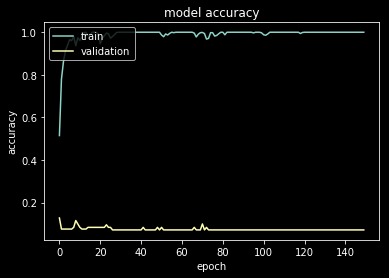

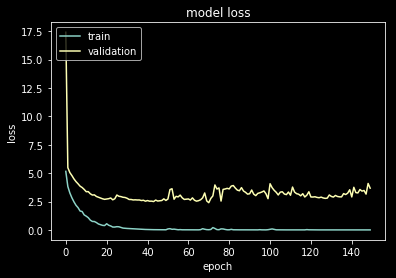

In [180]:
# https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



[0.0230877  0.01734202 0.02231598 0.8248517  0.01606028 0.01751642
 0.02165118 0.0197782  0.01992439 0.01747205]
        labels      pred  class
0  t_shirt_top  0.023088  False
1      trouser  0.017342  False
2     pullover  0.022316  False
3        dress  0.824852   True
4         coat  0.016060  False
5       sandal  0.017516  False
6        shirt  0.021651  False
7      sneaker  0.019778  False
8          bag  0.019924  False
9  ankle_boots  0.017472  False


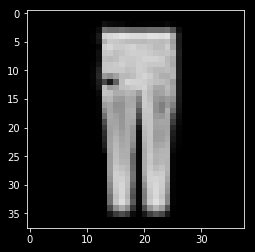

In [181]:

img = test_images[200]

imgs_in =[]
imgs_in.append(img)
imgs_in = np.array(imgs_in)
pred_output = final_model.predict(imgs_in).squeeze()
print(pred_output)
labels=['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


import pandas as pd

outputs = pd.DataFrame(
    data = {
        "pred" : np.round(pred_output,6), 
        "labels" : labels
    } )

# print(outputs)

outputs['class'] = outputs.pred > .5

print(outputs)

plt.imshow(img)
plt.show()

In [183]:


import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in final_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f5f63f175f8>,input_7,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7f5f63f171d0>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x7f5f63f170b8>,conv1,False
3,<keras.layers.normalization.BatchNormalization object at 0x7f5f5f055278>,bn_conv1,False
4,<keras.layers.core.Activation object at 0x7f5f81d0cc50>,activation_301,False
5,<keras.layers.convolutional.ZeroPadding2D object at 0x7f5f7c575e80>,pool1_pad,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f5f5ef3c6a0>,max_pooling2d_7,False
7,<keras.layers.convolutional.Conv2D object at 0x7f5f5ef1f780>,res2a_branch2a,False
8,<keras.layers.normalization.BatchNormalization object at 0x7f5f5ee395f8>,bn2a_branch2a,False
9,<keras.layers.core.Activation object at 0x7f5f5ee39f98>,activation_302,False
